In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from IPython.display import Markdown as md
import cosmology_plots as co_pl

# get working directory, where the runs and routines should be stored
dir0 = os.getcwd() + '/'
HOME = dir0 + '/..'

os.chdir(HOME)
import cosmology as co
import plot_sets
os.chdir(dir0)

####
#### Author: Alberto Roper Pol
#### created: 01/12/2022
####

### We solve Friedmann equations to obtain $\eta$, $a$, ${\cal H}$, $a''/a$ that is required by the Pencil Code to solve the GW equation over cosmological simulations.

### The notebook cosmology.ipynb includes detailed calculations and information on Friedmann equations and the solver, using the functions in cosmology.py

### This solver has been developed for the work Y. He, A. Roper Pol, A. Brandenburg, "Modified propagation of gravitational waves from the early radiation era," in press, JCAP (2023), arXiv:2212.06082.

In [4]:
print('DESCRIPTION: \n', co.__doc__)

#### To see all the available functions in cosmology.py and their description
#### uncomment the following line
# print(help(co))

DESCRIPTION: 
 
cosmology.py is a Python routine that contains functions relevant
for cosmological calculations, including a solver to Friedmann equations.

Author: Alberto Roper Pol
Date: 27/11/2022



In [5]:
# Constants of the model are taken from Planck 2018 and stored in cosmology.py
OmL0 = co.OmL0_ref      # Dark energy density as a fraction of present-time critical energy density
h0 = co.h0_ref          # Hubble rate H0 = 100 h0 km/s/Mpc

# N effective is taken to be 3 (see cosmology.py)
Neff = co.Neff_ref      # effective number of neutrino species

# Array of scale factors
a = np.logspace(-20, 2, 10000)

In [13]:
# Use Friedmann solver to compute the cosmic and conformal time as functions of the scale
# factor a (only needed to be done once to generate the solutions)

# If this has already been solved once, you can go ahead below and directly read the file a_vs_eta.dat

print('cosmology.friedmann_solver \n', co.friedmann_solver.__doc__)
t, eta, Om_tot, Om_rad, Om_mat, w, ad, add, ap, app = \
        co.friedmann_solver(a, a0=1., h0=h0, OmL0=OmL0, dofs=True, Neff=Neff,
                            return_all=True, save=True)

cosmology.friedmann_solver 
 
    Function that uses Friedmann equations and solve them numerically to obtain
    the evolution of a(\eta) and a(t) using the Omega distribution obtained from
    the function Omega_vs_a.
    
    A tutorial is available under cosmology/cosmology.ipynb
    
    Arguments:
        a -- array of scale factors
        dir0 -- directory where the file of dof is stored ('/cosmology/' directory by default)
        a0 -- reference value of the scale factor at present time (default is 1)
        h0 -- present-time value of the Hubble rate H0 = h0 x 100 km/s/Mpc
              (default is 67.32 km/s/Mpc based on CMB observations)
        OmL0 -- present-time content of dark energy (default is 0.6841)
        dofs -- option to compensate the rad energy density using dofs during RD era
        Neff -- effective number of neutrino species (default is 3)
        return_all -- option to return all variables used in the Friedmann solver
        save -- option to save th

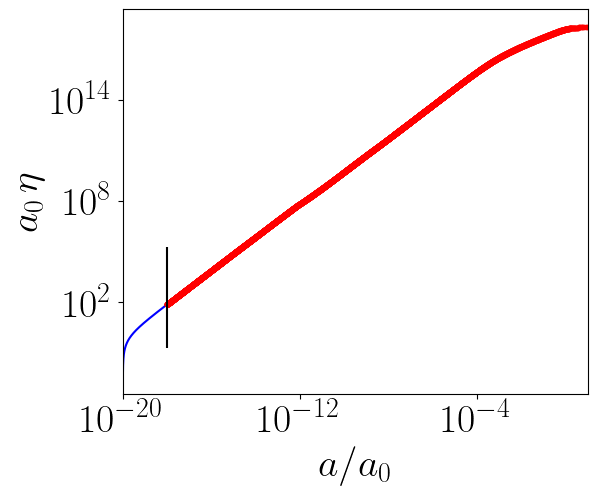

In [7]:
### For the Pencil Code, we generate an array of conformal times eta
### that are equidistant in logspace

etas_num = np.logspace(np.log10(eta[1].value), np.log10(eta[-1].value), 10000)
a_num = np.interp(etas_num, eta.value, a)
H_num = np.interp(etas_num, eta.value, ap.value/a)
Hpp_num = np.interp(etas_num, eta.value, app.value/a)

#### cut the values at small a that have some numerical artifacts
#### from the initial conditions
#### we take a > 1e-18
a_good = a_num[np.where(a_num >= 1e-18)]
eta_good = etas_num[np.where(a_num >= 1e-18)]
Hp_good = H_num[np.where(a_num >= 1e-18)]
Hpp_good = Hpp_num[np.where(a_num >= 1e-18)]

### plot to check we are taking correct values
plot = True
if plot:
    plt.figure(figsize=(6, 5))
    plt.plot(a_num, etas_num, color='blue')
    plt.loglog()
    plt.xlim(1e-20, 1e1)
    plt.plot(a_good, eta_good, '.', color='red')
    plt.vlines(1e-18, 2e-1, 2e5, color='black')
    plt.xlabel(r'$a/a_0$')
    plt.ylabel(r'$a_0 \, \eta$')

In [5]:
#### Write file that is read by the Pencil Code
# First line contains some info used to interpolate values within the
# the Pencil Code
# Rest of lines contain eta, a, a'/a and a''/a

H0 = co.H0_ref*co.h0_ref

with open('friedmann/a_vs_eta.dat', 'w') as f:
    f.write('%i, %.15f, %.15f, %.15e, %.4f \n'%(len(eta_good), np.log10(eta_good[0]), 
                               np.log10(eta_good[1]/eta_good[0]), H0.value, 1-OmL0))
    for i in range(0, len(a_good)):
        f.write('%.15e %.15e %.15e %.15e \n'%(eta_good[i], a_good[i],
                                              Hp_good[i], Hpp_good[i]))

In [6]:
## From now on we only use the stored values
a = a_good
eta = eta_good
ap_a = Hp_good
app_a = Hpp_good

In [9]:
## Otherwise we can directly read it from the stored file
## and start from here

import pandas as pd
fl = 'friedmann/a_vs_eta.dat'
df = pd.read_csv(fl, skiprows=1, header=None, names=['eta', 'a', 'HH', 'app_a', 'd'], delimiter=' ')
a = np.array(df['a'])
eta = np.array(df['eta'])
ap_a = np.array(df['HH'])
app_a = np.array(df['app_a'])

In [10]:
##### We choose an initial temperature scale corresponding to the time of GW generation
##### to obtain normalized variables.

# Choice of the initial time and computation of scale factor and Hubble rate
T = 100*u.GeV
g = co.thermal_g(T=T, s=0)
ast = co.as_a0_rat(T=T, g=g)
Hs = co.Hs_val(T=T, g=g)

#### Once we have solved and prepared the file for the Pencil Code, we can now use the results from the code.

#### The Pencil Code uses normalized units: $a$, $\eta$, ${\cal H}$, $a''/a$, so we need to define a specific time of GW generation.

In [11]:
md("### The initial time is the EWPT, for which $T_* = %i$ GeV,"%T.to(u.GeV).value + 
  " $g_* \\approx g_{\\rm S} \\simeq %.4f$"%g + "\n"
  "### The scale factor and Hubble rate are: \n" + 
  "#### $$\\frac{a_*}{a_0} = %.4f \\times 10^{-16} \\frac{T_*}{%i {\\rm \, GeV}}"%((100/g)**(-1/3)*ast*1e16, T.to(u.GeV).value) + 
  "\\biggl(\\frac{g_{\\rm S}}{100}\\biggr)^{-{1\over3}},$$" + "\n" + 
  "#### $$H_* = %.4f \\times 10^{10} {\\rm \, Hz} \,"%((100/g)**(1/2)*Hs.value*1e-10) + 
  "\\biggl(\\frac{T_*}{%i {\\rm \, GeV}}\\biggr)^2"%(T.to(u.GeV).value) + 
  "\\biggl(\\frac{g_*}{100}\\biggr)^{1\over2}$$")

### The initial time is the EWPT, for which $T_* = 100$ GeV, $g_* \approx g_{\rm S} \simeq 103.8264$
### The scale factor and Hubble rate are: 
#### $$\frac{a_*}{a_0} = 7.9709 \times 10^{-16} \frac{T_*}{100 {\rm \, GeV}}\biggl(\frac{g_{\rm S}}{100}\biggr)^{-{1\over3}},$$
#### $$H_* = 2.0659 \times 10^{10} {\rm \, Hz} \,\biggl(\frac{T_*}{100 {\rm \, GeV}}\biggr)^2\biggl(\frac{g_*}{100}\biggr)^{1\over2}$$

In [15]:
## compute normalized variables

print('\n cosmology.normalized_variables \n', co.normalized_variables.__doc__)
a_n, eta_n, HH_n, app_a_n, Omega, w, eta_n_0, aEQ_n, \
    aL_n, a_acc_n, eta_n_EQ, eta_n_L, eta_n_acc = \
        co.normalized_variables(a, eta, ap_a, app_a, T=T, h0=h0)


 cosmology.normalized_variables 
 
    Function that computes the normalized a, eta, HH, a'' for a given specific
    initial time of GW generation, which are required to be used in the Pencil Code.
    
    A tutorial is available under cosmology/cosmology_PC.ipynb
    
    Arguments:
        a -- scale factors, normalized to present-time a_0 = 1
        eta -- conformal times, normalized to present-time a_0 = 1
        ap_a -- conformal Hubble time a'/a, normalized to present-time a_0 = 1
        app_a -- a''/a, normalized to present-time a_0 = 1
        dir0 -- directory where the file of dof is stored ('/cosmology/' directory by default)
        T -- temperature scale at the time of generation in energy units
             (default is 100 GeV)
        h0 -- present-time value of the Hubble rate H0 = h0 x 100 km/s/Mpc
              (default is 67.32 km/s/Mpc based on CMB observations)
              
    Returns:
        a_n -- normalized scale factor a/a_*
        eta_n -- normalize


 cosmology_plots.plot_an_vs_etan 
 
    Function that plots the normalized scale factor vs the normalized
    conformal time.
    
    Arguments:
        eta_n -- array of normalized conformal time
        a_n -- array of normalized scale factors
        eta_n_0 -- normalized conformal time at present time
        eta_n_EQ -- normalized conformal time at equipartition
        ast -- scale factor at the initial time 
        epoch -- time of generation (default is EWPT)
        save -- option to save the plot under
                'friedmann/plots/an_vs_etan_' + epoch +'.pdf'
    


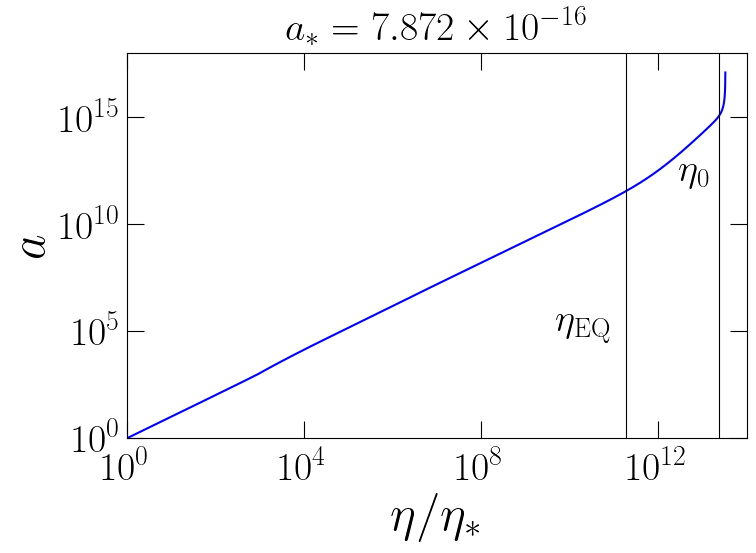

In [16]:
### plot a vs conformal time (normalized)
print('\n cosmology_plots.plot_an_vs_etan \n', co_pl.plot_an_vs_etan.__doc__)
co_pl.plot_an_vs_etan(eta_n, a_n, eta_n_0, eta_n_EQ, ast, epoch='EWPT', save=True)


 cosmology_plots.plot_HHn_vs_etan 
 
    Function that plots the normalized conformal Hubble rate vs the normalized
    conformal time.
    
    Arguments:
        eta_n -- array of normalized conformal time
        HH_n -- array of normalized conformal Hubble rate
        eta_n_0 -- normalized conformal time at present time
        eta_n_EQ -- normalized conformal time at equipartition
        ast -- scale factor at the initial time 
        epoch -- time of generation (default is EWPT)
        save -- option to save the plot under
                'friedmann/plots/HHn_vs_etan_' + epoch +'.pdf'
    


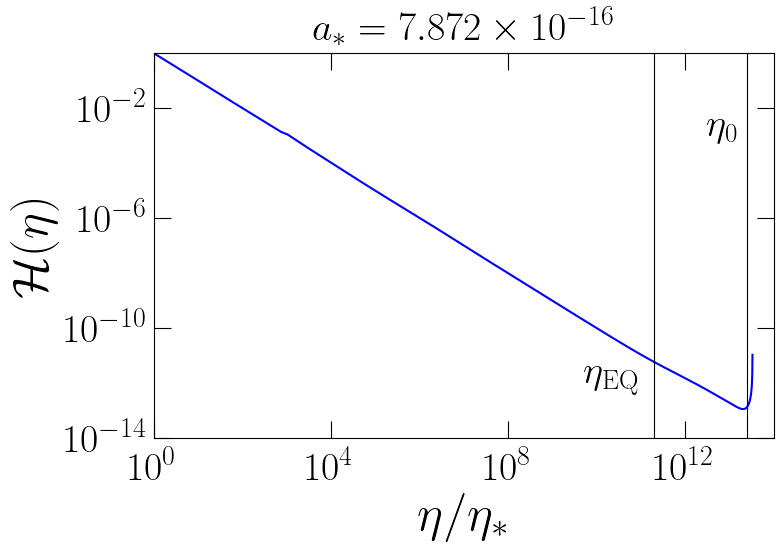

In [18]:
### plot conformal Hubble rate vs conformal time (normalized)
print('\n cosmology_plots.plot_HHn_vs_etan \n', co_pl.plot_HHn_vs_etan.__doc__)
co_pl.plot_HHn_vs_etan(eta_n, HH_n, eta_n_0, eta_n_EQ, ast, epoch='EWPT', save=True)


 cosmology_plots.plot_app_a_n_vs_etan 
 
    Function that plots the normalized a''/a vs the normalized
    conformal time.
    
    Arguments:
        eta_n -- array of normalized conformal time
        app_a_n -- array of normalized a''/a
        eta_n_0 -- normalized conformal time at present time
        eta_n_EQ -- normalized conformal time at equipartition
        ast -- scale factor at the initial time 
        epoch -- time of generation (default is EWPT)
        save -- option to save the plot under
                'friedmann/plots/app_n_vs_etan_' + epoch +'.pdf'
    


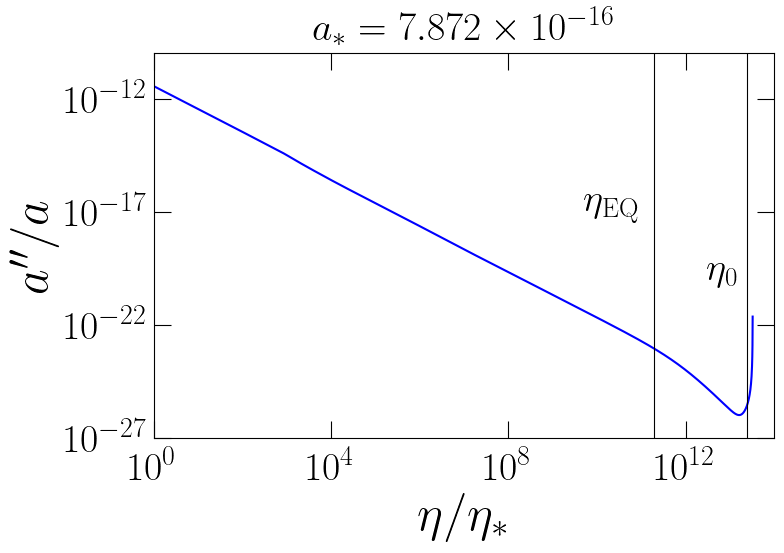

In [19]:
### plot a''/a vs conformal time (normalized)
print('\n cosmology_plots.plot_app_a_n_vs_etan \n', co_pl.plot_app_a_n_vs_etan.__doc__)
co_pl.plot_app_a_n_vs_etan(eta_n, app_a_n, eta_n_0, eta_n_EQ, ast, epoch='EWPT', save=True)

In [20]:
md("### The maximum value of $a''/a$ occurs at the time of generation $\eta = \eta_*$. It can be computed as: \n"+
  "### $$ \\frac{a''}{a} = \\frac{1}{2} {\cal H}^2 [1 - 3w(a)] \\approx " + 
  "\\frac{1}{2} \\frac{\Omega_{{\\rm mat}, 0}}{\Omega_{{\\rm rad}, 0}} \\frac{g_*^0}{g_*}" + 
  "\\biggl(\\frac{g_{\\rm S}}{g_{\\rm S}^0}\\biggr)^{{4\over3}}  {\cal H}\,  \\frac{a_*}{a_0}$$\n" + 
  "### Let's show how good is this approximation!")

### The maximum value of $a''/a$ occurs at the time of generation $\eta = \eta_*$. It can be computed as: 
### $$ \frac{a''}{a} = \frac{1}{2} {\cal H}^2 [1 - 3w(a)] \approx \frac{1}{2} \frac{\Omega_{{\rm mat}, 0}}{\Omega_{{\rm rad}, 0}} \frac{g_*^0}{g_*}\biggl(\frac{g_{\rm S}}{g_{\rm S}^0}\biggr)^{{4\over3}}  {\cal H}\,  \frac{a_*}{a_0}$$
### Let's show how good is this approximation!


 cosmology.ratio_app_a_n_factor 
 
    Function that computes the ratio of a''/a (normalized) to conformal Hubble rate H (normalized)
    times a_*/a_0 using an approximation valid during the RD era.
    
    Reference: Y. He, A. Roper Pol, A. Brandenburg, "Modified propagation of gravitational
    waves from the early radiation era," in press, JCAP (2022), arXiv:2212.06082,
    eq. 3.11
    
    Arguments:
        a -- array of scale factors
        dir0 -- directory where the file of dof is stored ('/cosmology/' directory by default)
        a0 -- reference value of the scale factor at present time (default is 1)
        h0 -- present-time value of the Hubble rate H0 = h0 x 100 km/s/Mpc
              (default is 67.32 km/s/Mpc based on CMB observations)
        OmL0 -- present-time content of dark energy (default is 0.6841)
        dofs -- option to compensate the rad energy density using dofs during RD era
        Neff -- effective number of neutrino species (default is 3)
        

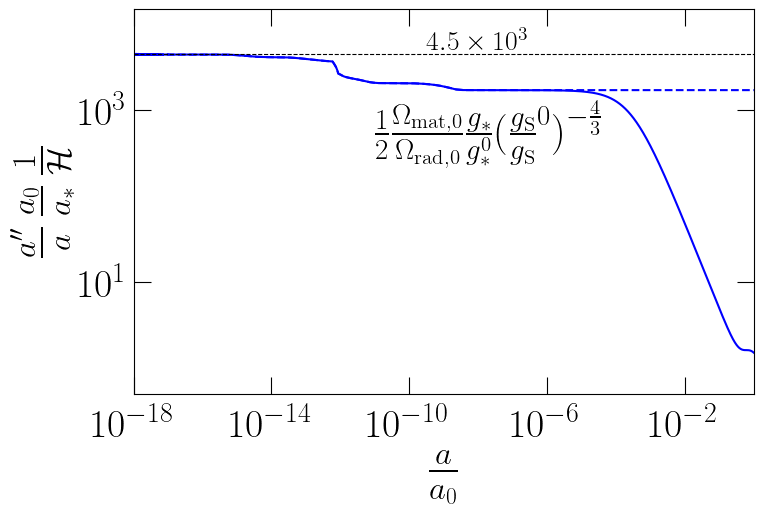

In [21]:
### value of the normalized a''/a compensated by a_* and HH
app_a_n = app_a/ap_a**2
print('\n cosmology.ratio_app_a_n_factor \n', co.ratio_app_a_n_factor.__doc__)
fact_app = co.ratio_app_a_n_factor(a, h0=h0, OmL0=OmL0, dofs=True, Neff=Neff)

#print('\n cosmology_plots.plot_factor_app_a_normalized \n', co_pl.plot_factor_app_a_normalized.__doc__)
co_pl.plot_factor_app_a_normalized(a, app_a_n, fact_app, epoch='EWPT', save=True)